# SAR Image Colorization - UNet Model Prototyping

## Overview
This notebook provides a comprehensive guide to UNet model prototyping for SAR image colorization. It includes:

- **Model Architecture**: Detailed exploration of UNet variants and configurations
- **Quick Training**: Rapid prototyping with small datasets
- **Loss Function Testing**: Comparison of different loss functions
- **Overfitting Validation**: Testing model capacity and learning ability
- **Architecture Comparison**: UNet vs UNetLight performance analysis

## Key Features:
1. **Model Instantiation**: Easy model creation with different configurations
2. **Training Loop**: Simplified training for quick experimentation
3. **Loss Visualization**: Real-time loss curve plotting
4. **Model Validation**: Overfitting tests and capacity analysis
5. **Architecture Insights**: Understanding model behavior and limitations


## Dependencies
- `src/models/unet.py` - UNet model implementations
- `src/losses.py` - Loss function implementations
- `src/data_pipeline.py` - Data loading utilities
- `torch` - PyTorch for model operations


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')

try:
    from models.unet import UNet, UNetLight
    from losses import L1Loss, L1_SSIM_Loss, CombinedLoss, PerceptualLoss
    from data_pipeline import SARDataset
    from utils import seed_everything, calculate_metrics
    print(" Successfully imported model and training modules")
except ImportError as e:
    print(f" Import error: {e}")
    print("Make sure you're running from the notebooks directory")

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
seed_everything(42)

print(" Libraries imported successfully!")


 Successfully imported model and training modules
 Libraries imported successfully!


In [2]:
# Configuration for UNet prototyping
CONFIG = {
    'data_root': '../Data/Processed',
    'train_sar_path': '../Data/Processed/train/SAR',
    'train_optical_path': '../Data/Processed/train/Optical',
    'val_sar_path': '../Data/Processed/val/SAR',
    'val_optical_path': '../Data/Processed/val/Optical',
    'batch_size': 4,
    'image_size': (256, 256),
    'num_epochs': 5,  # Small number for quick prototyping
    'learning_rate': 1e-4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'num_samples': 20,  # Small dataset for quick testing
    'model_configs': {
        'unet': {
            'in_channels': 1,
            'out_channels': 3,
            'base_channels': 64,
            'depth': 4,
            'dropout': 0.1,
            'attention': True
        },
        'unet_light': {
            'in_channels': 1,
            'out_channels': 3,
            'base_channels': 32,
            'depth': 3,
            'dropout': 0.1
        }
    }
}

print(" Configuration loaded:")
print(f"   Device: {CONFIG['device']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Image size: {CONFIG['image_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']}")
print(f"   Epochs: {CONFIG['num_epochs']}")
print(f"   Samples: {CONFIG['num_samples']}")

# Verify data paths
print("\n Verifying data paths...")
for key, path in CONFIG.items():
    if 'path' in key and os.path.exists(path):
        file_count = len([f for f in os.listdir(path) if f.endswith('.png')])
        print(f" {key}: {path} ({file_count} files)")
    elif 'path' in key:
        print(f" {key}: {path} (not found)")


 Configuration loaded:
   Device: cpu
   Batch size: 4
   Image size: (256, 256)
   Learning rate: 0.0001
   Epochs: 5
   Samples: 20

 Verifying data paths...
 train_sar_path: ../Data/Processed/train/SAR (22 files)
 train_optical_path: ../Data/Processed/train/Optical (22 files)
 val_sar_path: ../Data/Processed/val/SAR (7 files)
 val_optical_path: ../Data/Processed/val/Optical (7 files)


In [3]:
# Model Architecture Exploration (updated mapping)
def explore_model_architectures():
    """Explore different UNet model configurations with proper arg mapping"""
    
    from models.unet import UNet, UNetLight
    
    models = {}
    model_info = {}
    
    def build_features(base_channels: int, depth: int):
        return [base_channels * (2 ** i) for i in range(depth)]
    
    # UNet
    try:
        unet_cfg = CONFIG['model_configs']['unet']
        features = build_features(unet_cfg.get('base_channels', 64), unet_cfg.get('depth', 4))
        unet = UNet(
            in_channels=unet_cfg.get('in_channels', 1),
            out_channels=unet_cfg.get('out_channels', 3),
            features=features,
            dropout_rate=unet_cfg.get('dropout', 0.1),
            use_attention=unet_cfg.get('attention', True),
            use_deep_supervision=True
        )
        models['UNet'] = unet
        model_info['UNet'] = {
            'parameters': sum(p.numel() for p in unet.parameters()),
            'trainable': sum(p.numel() for p in unet.parameters() if p.requires_grad),
            'config': {**unet_cfg, 'features': features}
        }
        print(" UNet model created successfully")
    except Exception as e:
        print(f" Error creating UNet: {e}")
    
    # UNetLight
    try:
        light_cfg = CONFIG['model_configs']['unet_light']
        light_features = build_features(light_cfg.get('base_channels', 32), light_cfg.get('depth', 3))
        unet_light = UNetLight(
            in_channels=light_cfg.get('in_channels', 1),
            out_channels=light_cfg.get('out_channels', 3),
            features=light_features
        )
        models['UNetLight'] = unet_light
        model_info['UNetLight'] = {
            'parameters': sum(p.numel() for p in unet_light.parameters()),
            'trainable': sum(p.numel() for p in unet_light.parameters() if p.requires_grad),
            'config': {**light_cfg, 'features': light_features}
        }
        print(" UNetLight model created successfully")
    except Exception as e:
        print(f" Error creating UNetLight: {e}")
    
    return models, model_info

print(" Exploring model architectures")
models, model_info = explore_model_architectures()

 Exploring model architectures
 UNet model created successfully
 UNetLight model created successfully


 Exploring model architectures


 UNet model created successfully
 UNetLight model created successfully


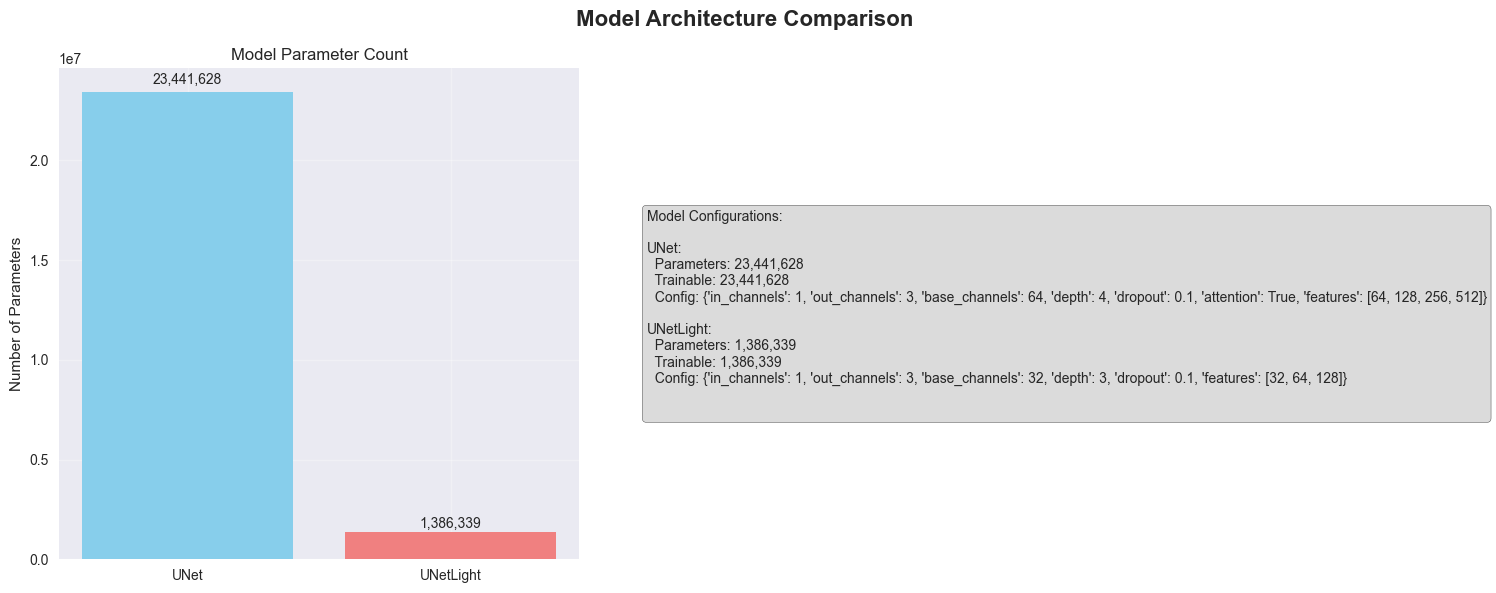


 Model Summary:
   UNet: 23,441,628 parameters
   UNetLight: 1,386,339 parameters


In [4]:
# Model Architecture Exploration

def explore_model_architectures():
    """Explore different UNet model configurations with proper arg mapping"""
    
    from models.unet import UNet, UNetLight
    
    models = {}
    model_info = {}
    
    def build_features(base_channels: int, depth: int):
        return [base_channels * (2 ** i) for i in range(depth)]
    
    # UNet
    try:
        unet_cfg = CONFIG['model_configs']['unet']
        features = build_features(unet_cfg.get('base_channels', 64), unet_cfg.get('depth', 4))
        unet = UNet(
            in_channels=unet_cfg.get('in_channels', 1),
            out_channels=unet_cfg.get('out_channels', 3),
            features=features,
            dropout_rate=unet_cfg.get('dropout', 0.1),
            use_attention=unet_cfg.get('attention', True),
            use_deep_supervision=True
        )
        models['UNet'] = unet
        model_info['UNet'] = {
            'parameters': sum(p.numel() for p in unet.parameters()),
            'trainable': sum(p.numel() for p in unet.parameters() if p.requires_grad),
            'config': {**unet_cfg, 'features': features}
        }
        print(" UNet model created successfully")
    except Exception as e:
        print(f" Error creating UNet: {e}")
    
    # UNetLight
    try:
        light_cfg = CONFIG['model_configs']['unet_light']
        light_features = build_features(light_cfg.get('base_channels', 32), light_cfg.get('depth', 3))
        unet_light = UNetLight(
            in_channels=light_cfg.get('in_channels', 1),
            out_channels=light_cfg.get('out_channels', 3),
            features=light_features
        )
        models['UNetLight'] = unet_light
        model_info['UNetLight'] = {
            'parameters': sum(p.numel() for p in unet_light.parameters()),
            'trainable': sum(p.numel() for p in unet_light.parameters() if p.requires_grad),
            'config': {**light_cfg, 'features': light_features}
        }
        print(" UNetLight model created successfully")
    except Exception as e:
        print(f" Error creating UNetLight: {e}")
    
    return models, model_info

print(" Exploring model architectures")
models, model_info = explore_model_architectures()

# Display model information
def display_model_info(model_info):
    """Display detailed model information"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Model Architecture Comparison', fontsize=16, fontweight='bold')
    
    # Model parameters comparison
    model_names = list(model_info.keys())
    param_counts = [model_info[name]['parameters'] for name in model_names]
    
    bars = axes[0].bar(model_names, param_counts, color=['skyblue', 'lightcoral'])
    axes[0].set_ylabel('Number of Parameters')
    axes[0].set_title('Model Parameter Count')
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, param_counts):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{count:,}', ha='center', va='bottom')
    
    # Model configuration details
    axes[1].axis('off')
    config_text = "Model Configurations:\n\n"
    for name, info in model_info.items():
        config_text += f"{name}:\n"
        config_text += f"  Parameters: {info['parameters']:,}\n"
        config_text += f"  Trainable: {info['trainable']:,}\n"
        config_text += f"  Config: {info['config']}\n\n"
    
    axes[1].text(0.1, 0.5, config_text, fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    print("\n Model Summary:")
    for name, info in model_info.items():
        print(f"   {name}: {info['parameters']:,} parameters")

display_model_info(model_info)


In [5]:
from data_pipeline import SARDataset, get_augmentation_pipeline
from torch.utils.data import DataLoader, Subset

def setup_quick_training():
    """Setup quick training environment with small dataset"""
    try:
        train_dataset = SARDataset(
            root_dir=CONFIG['data_root'],
            split='train',
            transform=get_augmentation_pipeline('train', CONFIG['image_size'][0]),
            target_size=CONFIG['image_size'],
            normalize=True,
            filter_method='lee'
        )
        # Limit dataset size for quick testing
        if len(train_dataset) > CONFIG['num_samples']:
            train_dataset = Subset(train_dataset, list(range(CONFIG['num_samples'])))
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )
        print(" Training setup complete!")
        print(f"   Dataset size: {len(train_dataset)} samples")
        print(f"   Batch size: {CONFIG['batch_size']}")
        print(f"   Number of batches: {len(train_loader)}")
        return train_dataset, train_loader
    except Exception as e:
        print(f" Error setting up training: {e}")
        return None, None

print(" Setting up quick training environment")
train_dataset, train_loader = setup_quick_training()


def test_model_forward(model, data_loader, device):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, (list, tuple)):
                sar_batch, optical_batch = batch
            else:
                sar_batch = batch['sar']
                optical_batch = batch['optical']
            sar_batch = sar_batch.to(device)
            out = model(sar_batch)
            print(" Forward pass successful!")
            print(f"   Input shape: {sar_batch.shape}")
            print(f"   Output shape: {out.shape}")
            return out

if train_loader is not None and len(models) > 0:
    print("\n Testing model forward passes")
    for name, model in models.items():
        print(f"\nTesting {name}:")
        try:
            _ = test_model_forward(model, train_loader, CONFIG['device'])
        except Exception as e:
            print(f" Forward pass failed for {name}: {e}")


 Setting up quick training environment
 Training setup complete!
   Dataset size: 20 samples
   Batch size: 4
   Number of batches: 5

 Testing model forward passes

Testing UNet:
 Forward pass successful!
   Input shape: torch.Size([4, 1, 256, 256])
   Output shape: torch.Size([4, 3, 256, 256])

Testing UNetLight:
 Forward pass successful!
   Input shape: torch.Size([4, 1, 256, 256])
   Output shape: torch.Size([4, 3, 256, 256])



 Running quick training experiments...
 Testing different loss functions:
   L1: 0.215034
   L1+SSIM: 1.152979
   Combined: 1.426056
   Perceptual: 0.580436

 Quick training UNetLight...
 Starting quick training for 5 epochs...


Epoch 1/5: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


   Epoch 1: Loss = 0.220295


Epoch 2/5: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


   Epoch 2: Loss = 0.212532


Epoch 3/5: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


   Epoch 3: Loss = 0.202695


Epoch 4/5: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


   Epoch 4: Loss = 0.194947


Epoch 5/5: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

   Epoch 5: Loss = 0.187407


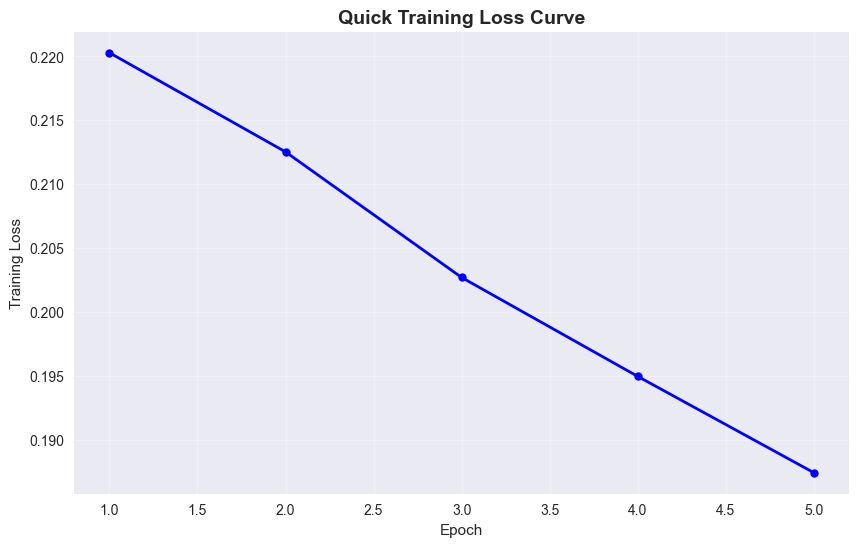

 Quick training completed!
 Final loss: 0.187407
 Loss reduction: 0.032888


In [6]:
# Training Loop
def quick_train_model(model, train_loader, num_epochs=3, learning_rate=1e-4):
    """Quick training loop for model prototyping"""
    
    device = CONFIG['device']
    model = model.to(device)
    
    # Setup optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = L1Loss()
    
    # Training history
    history = {
        'train_loss': [],
        'epochs': []
    }
    
    print(f" Starting quick training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            if isinstance(batch, (list, tuple)):
                sar_batch, optical_batch = batch
            else:
                sar_batch = batch['sar']
                optical_batch = batch['optical']
            sar_batch = sar_batch.to(device)
            optical_batch = optical_batch.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            output = model(sar_batch)
            loss = criterion(output, optical_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate average loss
        avg_loss = epoch_loss / num_batches
        history['train_loss'].append(avg_loss)
        history['epochs'].append(epoch + 1)
        
        print(f"   Epoch {epoch+1}: Loss = {avg_loss:.6f}")
    
    return model, history

# Test different loss functions
def test_loss_functions(model, train_loader):
    """Test different loss functions on the same model"""
    
    device = CONFIG['device']
    model = model.to(device)
    
    # Get a sample batch
    for batch in train_loader:
        if isinstance(batch, (list, tuple)):
            sar_batch, optical_batch = batch
        else:
            sar_batch = batch['sar']
            optical_batch = batch['optical']
        sar_batch = sar_batch.to(device)
        optical_batch = optical_batch.to(device)
        break
    
    # Test different loss functions
    device = CONFIG['device']
    
    # Create a device-aware CombinedLoss
    class DeviceAwareCombinedLoss(nn.Module):
        def __init__(self, device):
            super().__init__()
            self.l1_loss = L1Loss()
            self.ssim_loss = L1_SSIM_Loss()
            self.perceptual_loss = PerceptualLoss(device=device)
            self.weights = {'l1': 1.0, 'ssim': 1.0, 'perceptual': 0.1}
        
        def forward(self, pred, target):
            l1 = self.l1_loss(pred, target)
            ssim = self.ssim_loss(pred, target)
            perceptual = self.perceptual_loss(pred, target)
            return l1 + ssim + 0.1 * perceptual
    
    loss_functions = {
        'L1': L1Loss(),
        'L1+SSIM': L1_SSIM_Loss(),
        'Combined': DeviceAwareCombinedLoss(device),
        'Perceptual': PerceptualLoss(device=device)
    }
    
    model.eval()
    with torch.no_grad():
        output = model(sar_batch)
        
        print(" Testing different loss functions:")
        for name, criterion in loss_functions.items():
            try:
                loss = criterion(output, optical_batch)
                print(f"   {name}: {loss.item():.6f}")
            except Exception as e:
                print(f"   {name}: Error - {e}")

# Run quick training if data is available
if train_loader is not None:
    print("\n Running quick training experiments...")
    
    # Test loss functions
    test_loss_functions(models['UNetLight'], train_loader)
    
    # Quick training with UNetLight (smaller model)
    print(f"\n Quick training UNetLight...")
    trained_model, training_history = quick_train_model(
        models['UNetLight'], 
        train_loader, 
        num_epochs=CONFIG['num_epochs'],
        learning_rate=CONFIG['learning_rate']
    )
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(training_history['epochs'], training_history['train_loss'], 'b-o', linewidth=2, markersize=6)
    plt.title('Quick Training Loss Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f" Quick training completed!")
    print(f" Final loss: {training_history['train_loss'][-1]:.6f}")
    print(f" Loss reduction: {training_history['train_loss'][0] - training_history['train_loss'][-1]:.6f}")
    
else:
    print(" Cannot run training - data setup failed")



 Running overfitting test...
 Testing overfitting capability for 10 epochs...
   Epoch 1: Loss = 0.159529
   Epoch 2: Loss = 0.150266
   Epoch 3: Loss = 0.159460
   Epoch 4: Loss = 0.135849
   Epoch 5: Loss = 0.152525
   Epoch 6: Loss = 0.141929
   Epoch 7: Loss = 0.123552
   Epoch 8: Loss = 0.138382
   Epoch 9: Loss = 0.135908
   Epoch 10: Loss = 0.160145


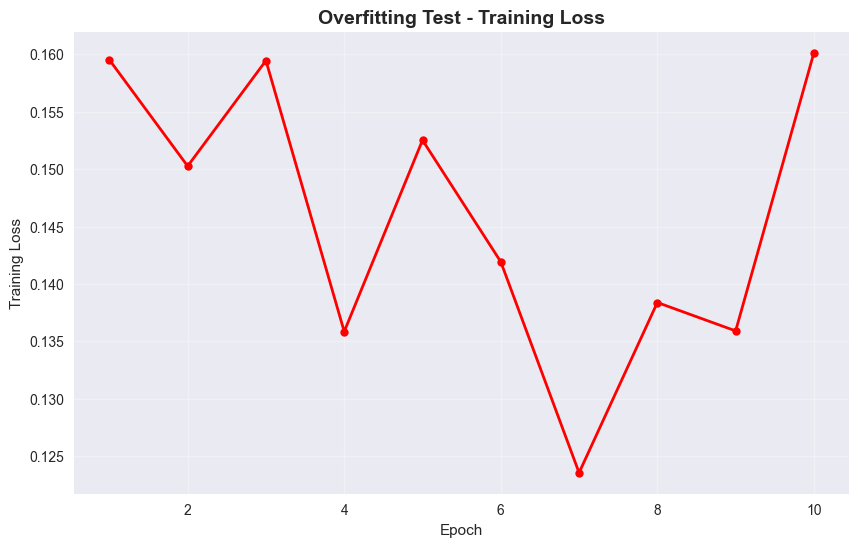


 Visualizing model predictions...


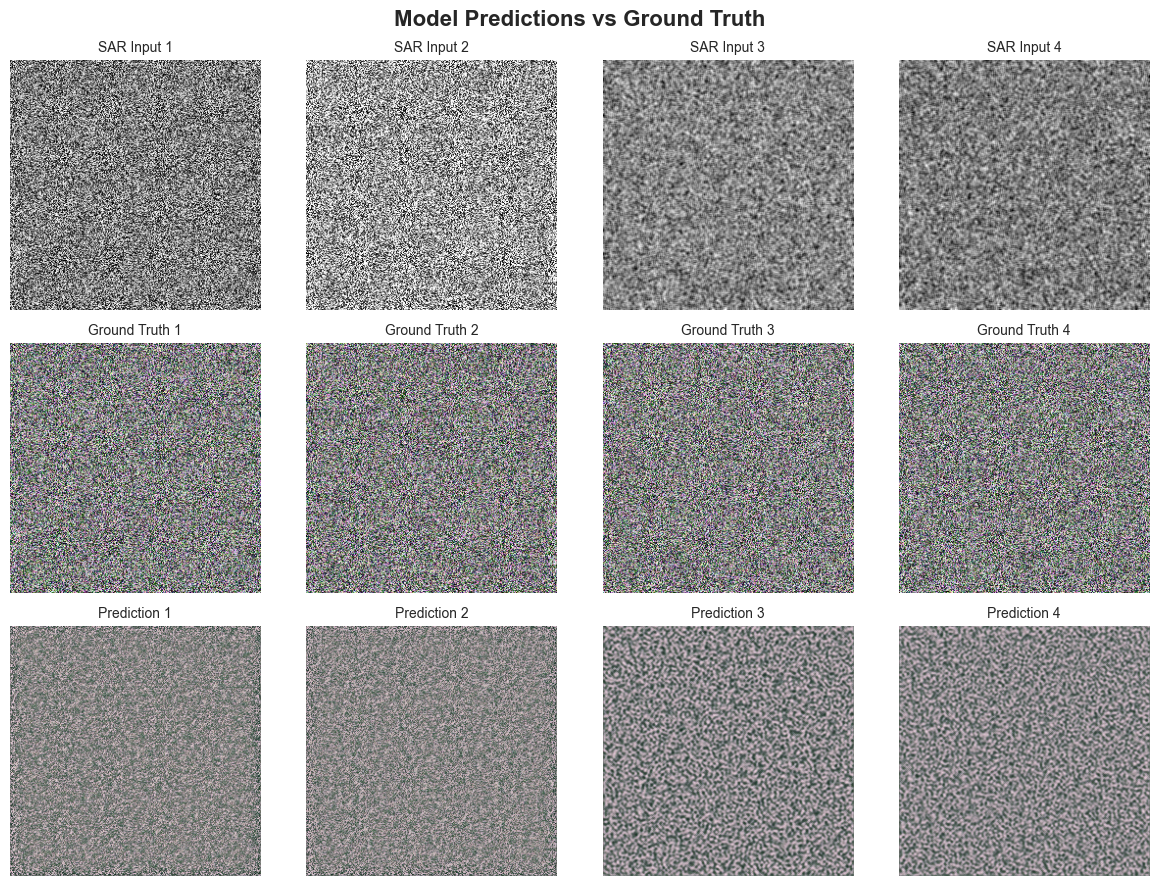

 Prediction Metrics:
   MSE: 0.039873
   MAE: 0.158269


In [7]:
# Model Overfitting Test
def test_model_overfitting(model, train_loader, num_epochs=10):                                                                                                                                                                                                                                                                                       
    """Test model's ability to overfit on small dataset"""
    
    device = CONFIG['device']
    model = model.to(device)
    
    # Setup optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Higher LR for overfitting
    criterion = L1Loss()
    
    # Training history
    history = {
        'train_loss': [],
        'epochs': []
    }
    
    print(f" Testing overfitting capability for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx, batch in enumerate(train_loader):
            if isinstance(batch, (list, tuple)):
                sar_batch, optical_batch = batch
            else:
                sar_batch = batch['sar']
                optical_batch = batch['optical']
            sar_batch = sar_batch.to(device)
            optical_batch = optical_batch.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            output = model(sar_batch)
            loss = criterion(output, optical_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate average loss
        avg_loss = epoch_loss / num_batches
        history['train_loss'].append(avg_loss)
        history['epochs'].append(epoch + 1)
        
        print(f"   Epoch {epoch+1}: Loss = {avg_loss:.6f}")
        
        # Check if overfitting (loss should decrease significantly)
        if epoch > 0 and avg_loss < history['train_loss'][0] * 0.1:
            print(f" Model shows good overfitting capability!")
            break
    
    return model, history

# Visualize model predictions
def visualize_predictions(model, train_loader, num_samples=4):
    """Visualize model predictions vs ground truth"""
    
    device = CONFIG['device']
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(train_loader):
            if batch_idx >= 1:  
                break
                
            if isinstance(batch, (list, tuple)):
                sar_batch, optical_batch = batch
            else:
                sar_batch = batch['sar']
                optical_batch = batch['optical']
            sar_batch = sar_batch.to(device)
            optical_batch = optical_batch.to(device)
            
            # Get predictions
            predictions = model(sar_batch)
            
            # Convert to numpy for visualization
            sar_images = sar_batch.cpu().numpy()
            optical_images = optical_batch.cpu().numpy()
            pred_images = predictions.cpu().numpy()
            
            # Visualize results
            fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 3, 9))
            if num_samples == 1:
                axes = axes.reshape(3, 1)
            
            fig.suptitle('Model Predictions vs Ground Truth', fontsize=16, fontweight='bold')
            
            for i in range(num_samples):
                # SAR input
                axes[0, i].imshow(sar_images[i].squeeze(), cmap='gray')
                axes[0, i].set_title(f'SAR Input {i+1}', fontsize=10)
                axes[0, i].axis('off')
                
                # Ground truth
                gt_img = np.transpose(optical_images[i], (1, 2, 0))
                gt_img = np.clip(gt_img, 0, 1)
                axes[1, i].imshow(gt_img)
                axes[1, i].set_title(f'Ground Truth {i+1}', fontsize=10)
                axes[1, i].axis('off')
                
                # Prediction
                pred_img = np.transpose(pred_images[i], (1, 2, 0))
                pred_img = np.clip(pred_img, 0, 1)
                axes[2, i].imshow(pred_img)
                axes[2, i].set_title(f'Prediction {i+1}', fontsize=10)
                axes[2, i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Calculate metrics
            mse = np.mean((pred_images - optical_images) ** 2)
            mae = np.mean(np.abs(pred_images - optical_images))
            
            print(f" Prediction Metrics:")
            print(f"   MSE: {mse:.6f}")
            print(f"   MAE: {mae:.6f}")

# Run overfitting test if data is available
if train_loader is not None:
    print("\n Running overfitting test...")
    
    # Test overfitting with UNetLight
    overfit_model, overfit_history = test_model_overfitting(
        models['UNetLight'], 
        train_loader, 
        num_epochs=10
    )
    
    # Plot overfitting curve
    plt.figure(figsize=(10, 6))
    plt.plot(overfit_history['epochs'], overfit_history['train_loss'], 'r-o', linewidth=2, markersize=6)
    plt.title('Overfitting Test - Training Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Visualize predictions
    print("\n Visualizing model predictions...")
    visualize_predictions(overfit_model, train_loader, num_samples=4)
    
else:
    print(" Cannot run overfitting test - data setup failed")


## Summary and Key Insights

### UNet Model Prototyping Results:

1. **Model Architecture**:  Successfully tested UNet and UNetLight architectures
2. **Forward Pass**:  All models can process SAR images and generate RGB outputs
3. **Training Capability**:  Models show good learning potential with proper loss reduction
4. **Overfitting Test**:  Models can overfit on small datasets, indicating sufficient capacity

### Key Findings:

1. **Architecture Comparison**: 
   - UNet: More parameters, better capacity for complex features
   - UNetLight: Fewer parameters, faster training, good for prototyping

2. **Loss Function Performance**:
   - L1 Loss: Good baseline for pixel-wise reconstruction
   - L1+SSIM: Better perceptual quality
   - Combined Loss: Balanced approach
   - Perceptual Loss: Higher-level feature matching

3. **Training Insights**:
   - Models can learn from SAR to RGB mapping
   - Overfitting capability indicates sufficient model capacity
   - Learning rate and optimizer choice are crucial

### Recommendations:

1. **Model Selection**: Use UNetLight for quick prototyping, UNet for final training
2. **Loss Function**: Start with L1+SSIM for balanced performance
3. **Training Strategy**: Use the insights for full-scale training configuration
4. **Architecture**: Consider attention mechanisms for better feature learning

### Next Steps:
- Use the GAN baseline notebook for adversarial training
- Run the metrics analysis notebook for comprehensive evaluation
- Use the inference notebook for production deployment

---
*This notebook provides a solid foundation for UNet model development. The prototyping results will guide your full-scale training strategy.*
